# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

# Magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the demographics data 
print("The demographics file has {} rows and {} columns\n".format(azdias.shape[0],azdias.shape[1]))
print(azdias.head())
azdias.describe()

The demographics file has 891221 rows and 85 columns

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...      

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
# Check the non-null value count and datatypes of the demographics data
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
# Check the structure of the feature summary file 
print("The feature summary file has {} rows and {} columns \n".format(feat_info.shape[0],feat_info.shape[1]))
print(feat_info.head())
feat_info.describe()

The feature summary file has 85 rows and 4 columns 

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [6]:
# Check the datatypes of the feature summary file
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Look at all the values in the 'missing_or_unknown' column of the feature summary file
feat_info['missing_or_unknown'].values

array(['[-1,0]', '[-1,0,9]', '[-1,0]', '[0]', '[-1]', '[-1]', '[-1]',
       '[-1]', '[-1]', '[-1]', '[-1]', '[0]', '[]', '[]', '[-1,0]', '[0]',
       '[0]', '[0]', '[0]', '[0]', '[0]', '[-1,0]', '[-1,0]', '[0]',
       '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]',
       '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]', '[-1,9]',
       '[-1,9]', '[-1,9]', '[-1]', '[-1]', '[-1,0]', '[-1]', '[-1,9]',
       '[0]', '[]', '[]', '[-1,0]', '[-1]', '[-1,0]', '[-1,0]', '[0]',
       '[]', '[-1,0]', '[]', '[0]', '[-1]', '[-1]', '[-1,X]', '[XX]',
       '[-1,XX]', '[-1]', '[-1]', '[-1]', '[-1]', '[-1,0]', '[-1,0]',
       '[-1]', '[-1]', '[-1]', '[]', '[-1,0]', '[]', '[]', '[-1,0]', '[]',
       '[-1]', '[-1]', '[-1]', '[-1]', '[-1,0]', '[-1]', '[-1]', '[-1,9]',
       '[-1,0]', '[-1,9]'], dtype=object)

In [8]:
# Print the NaN values count before the conversion
print("Total number of original NaNs:", azdias.isnull().sum().sum())

# Identify missing or unknown data values and convert them to NaNs
for i in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[i]['missing_or_unknown'].strip('[').strip(']').split(',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)

# Print the NaN values count after the conversion
print("Total number of NaNs after converting 'missing' and 'unknown' values:", azdias.isnull().sum().sum())

Total number of original NaNs: 4896838
Total number of NaNs after converting 'missing' and 'unknown' values: 8373929


In [9]:
# Make sure NaNs are populated where required
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the dataset
azdias.isnull().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

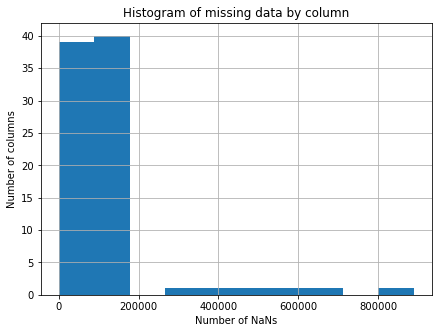

In [11]:
# Investigate patterns in the amount of missing data in each column
azdias.isnull().sum().hist(figsize = (7,5))
plt.title("Histogram of missing data by column")
plt.xlabel("Number of NaNs")
plt.ylabel("Number of columns");

In [12]:
# set the threshold to 20% of missing values
column_nans_threshold = np.round(0.2 * len(azdias)).astype(int)

# print the threshold value and the number of columns above the threshold
print("Threshold value is set at {} NaNs per column".format(column_nans_threshold))
print("Number of columns above the threshold value:", sum(azdias.isnull().sum() > column_nans_threshold))

# Create a list of columns above the threshold and columns with no NaNs. Remove the columns above the threshold from the dataset
columns_with_zero_nans = []
columns_with_many_nans = []
for column in azdias.columns:
    if azdias[column].isnull().sum() > column_nans_threshold:
        columns_with_many_nans.append(column)
        azdias = azdias.drop([column], axis=1)
    elif azdias[column].isnull().sum() == 0:
        columns_with_zero_nans.append(column)

# print the column names that are above the threshold and are removed
print("Columns that are removed are {}".format(columns_with_many_nans))

Threshold value is set at 178244 NaNs per column
Number of columns above the threshold value: 6
Columns that are removed are ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


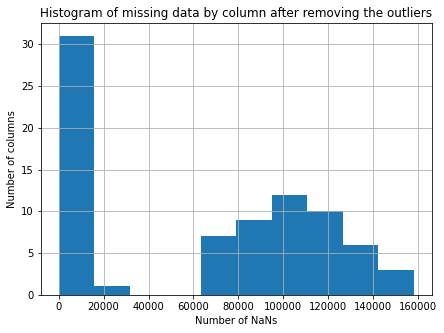

In [13]:
# Check the distribution after the columns above the threshold are removed
azdias.isnull().sum().hist(figsize = (7,5))
plt.title("Histogram of missing data by column after removing the outliers")
plt.xlabel("Number of NaNs")
plt.ylabel("Number of columns");

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the "Histogram of missing data by column", it is clear that the columns can be grouped into two sets based on the number of missing values: one over 200,000 missing values and another below 200,000 missing values. Only 6 columns fall into the first category (i.e. over 200,000 missing values) and they are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. These columns are removed from the dataset and there are 79 columns remaining.

After removing the 6 columns with high number of missing values, the remaining columns can be again grouped into two sets based on the number of missing values: 32 columns with less than 40,000 missing values each and 47 columns with more than 60,000 missing values each.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# Perform an assessment of how much data is missing in each row of the dataset
azdias.isnull().sum(axis=1)

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

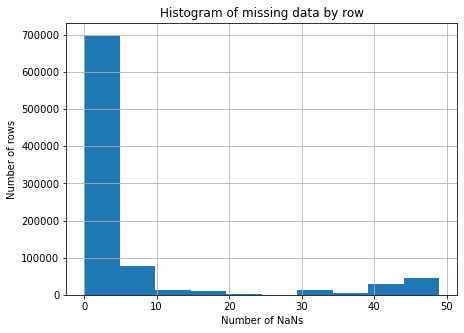

In [15]:
# Investigate patterns in the amount of missing data in each row
azdias.isnull().sum(axis=1).hist(figsize = (7,5))
plt.title("Histogram of missing data by row")
plt.xlabel("Number of NaNs")
plt.ylabel("Number of rows");

In [16]:
# Divide the data into two subsets based on the number of missing values in each row, which is set at 20
row_nans_threshold = 20
azdias_below_threshold = azdias[azdias.isnull().sum(axis=1) < row_nans_threshold]
azdias_above_threshold = azdias[azdias.isnull().sum(axis=1) >= row_nans_threshold]
print("Threshold value is set at {} NaNs per row".format(row_nans_threshold))
print("Number of rows below the threshold value:", azdias_below_threshold.shape[0])
print("Number of rows equal to or above the threshold value:", azdias_above_threshold.shape[0])

Threshold value is set at 20 NaNs per row
Number of rows below the threshold value: 797077
Number of rows equal to or above the threshold value: 94144


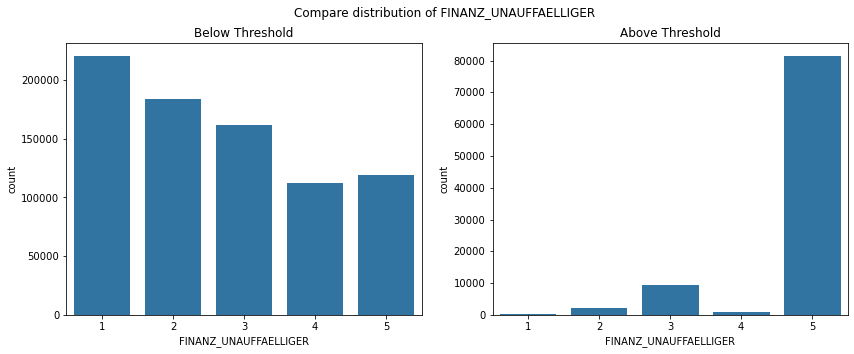

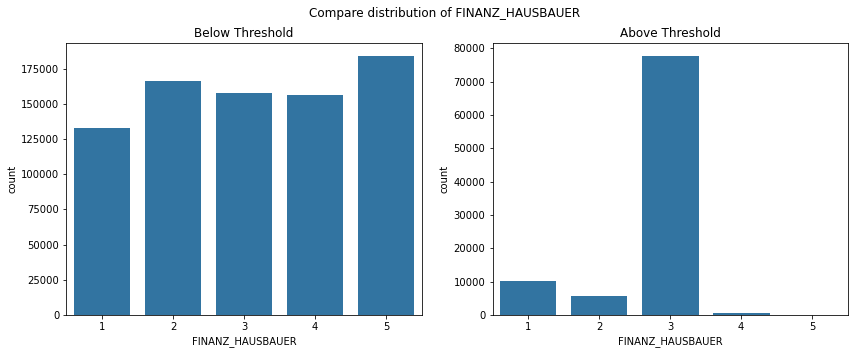

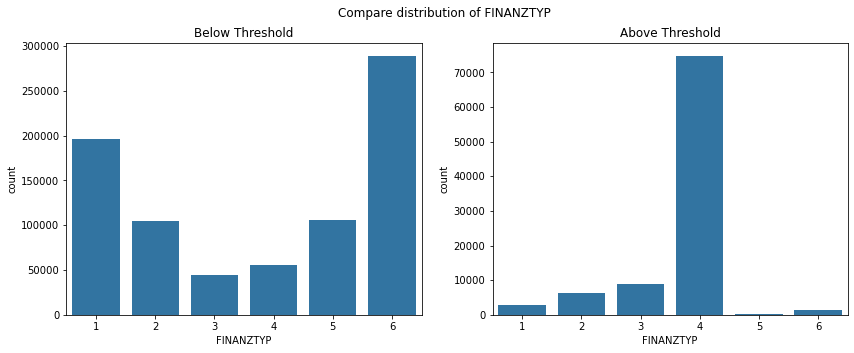

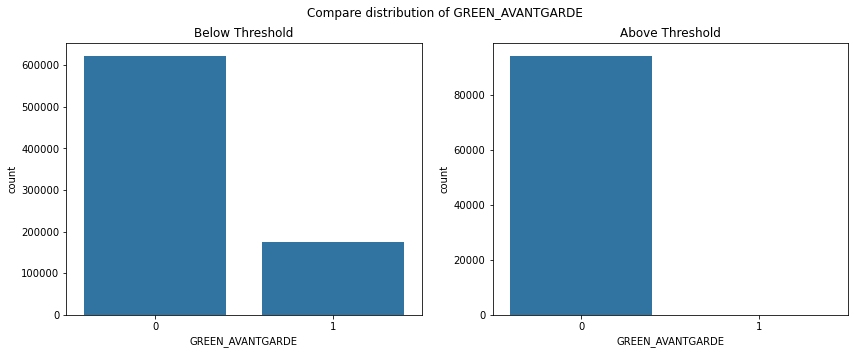

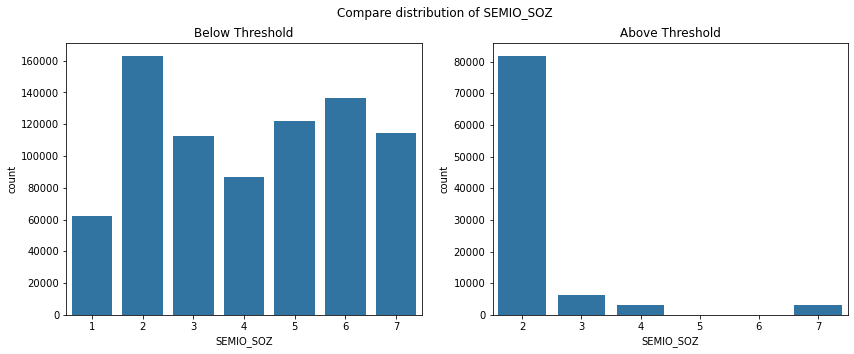

In [17]:
# Compare the distribution of values for at least 5 columns where there are no or few missing values, between the two subsets

# define a function to plot the distribution graph
def compare_distribution(column, set1, set2):
    '''
    Compare the distribution of a feature (variable) between two sets of datasets
    
    INPUT: column - feature to be compared
           set1 - dataset below the threshold
           set2 - dataset above the threshold
    
    OUTPUT: None
    '''
    f, axes = plt.subplots(1, 2, figsize = (14, 5))
    f.suptitle("Compare distribution of {}".format(column))
    axes[0].set_title("Below Threshold")
    axes[1].set_title("Above Threshold")
    base_color = sns.color_palette()[0]
    sns.countplot(x = column, data = set1, ax = axes[0], color = base_color)
    sns.countplot(x = column, data = set2, ax = axes[1], color = base_color)

# select 5 columns to compare
columns_to_compare = columns_with_zero_nans[5:10]

# call the function
for feature in columns_to_compare:
    compare_distribution(feature, azdias_below_threshold, azdias_above_threshold)

#### Discussion 1.1.3: Assess Missing Data in Each Row


Looking at the "Histogram of missing data by row', it is clear that majority of the rows have few (or less than 10) missing values per row. However, there are some outliers. Assuming a threshold of 20 missing values per row, the dataset is divided into sets - one above the threshold and one below the threshold. 

Comparing the distribution of some 5 features between these two datasets, it is found that the data with few missing values is quantitatively different from data with many missing values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
print(feat_info.type.values)
feat_info.groupby('type')['attribute'].count()

['categorical' 'ordinal' 'categorical' 'categorical' 'ordinal' 'ordinal'
 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'categorical' 'numeric'
 'categorical' 'categorical' 'ordinal' 'mixed' 'mixed' 'categorical'
 'categorical' 'categorical' 'categorical' 'categorical' 'mixed' 'ordinal'
 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal'
 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal'
 'categorical' 'categorical' 'categorical' 'categorical' 'categorical'
 'interval' 'numeric' 'numeric' 'ordinal' 'categorical' 'ordinal'
 'ordinal' 'numeric' 'numeric' 'categorical' 'ordinal' 'numeric'
 'categorical' 'mixed' 'categorical' 'categorical' 'mixed' 'ordinal'
 'ordinal' 'ordinal' 'ordinal' 'mixed' 'ordinal' 'ordinal' 'ordinal'
 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'numeric'
 'ordinal' 'ordinal' 'ordinal' 'ordinal' 'mixed' 'ordinal' 'ordinal'
 'ordinal' 'ordinal' 'ordinal']


type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

# extract and print categorical variables
categorical_variables = list(feat_info.query('type == "categorical"')['attribute'].values)
print("Categorical variables are:", categorical_variables)

# create a list of binary and multi-level categorical variables
binary_categorical_variables = []
multi_categorical_variables = []
for variable in categorical_variables:
    if variable not in columns_with_many_nans:
        if azdias_below_threshold[variable].nunique() == 2:
            binary_categorical_variables.append(variable)
        else:
            multi_categorical_variables.append(variable)

# print the two types of categorical variables
print("\nMulti-level categorical varibales are:", multi_categorical_variables)  
print("\nBinary categorical variables are:", binary_categorical_variables)

# for each binary categorical variables, print the values it contains
for variable in binary_categorical_variables:
    print("\nBinary categorical variable {} has values {}".format(variable, azdias_below_threshold[variable].unique()))

Categorical variables are: ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Multi-level categorical varibales are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Binary categorical variables are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Binary categorical variable ANREDE_KZ has values [2 1]

Binary categorical variable GREEN_AVANTGARDE has values [0 1]

Binary categorical variable SOHO_KZ has values [1. 0.]

Binary categorical variable VERS_TYP has values [ 2.  1. nan]

Binary categorical variable OS

In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
pd.options.mode.chained_assignment = None 
azdias_below_threshold.loc[(azdias_below_threshold.OST_WEST_KZ == 'W'),'OST_WEST_KZ'] = 1
azdias_below_threshold.loc[(azdias_below_threshold.OST_WEST_KZ == 'O'),'OST_WEST_KZ'] = 2

In [21]:
# Drop multi-level categorical variables
print("Shape before dropping multi-level categorical variables:", azdias_below_threshold.shape)
for variable in multi_categorical_variables:
    azdias_below_threshold = azdias_below_threshold.drop([variable], axis=1)
print("Shape after dropping multi-level categorical variables:", azdias_below_threshold.shape)

Shape before dropping multi-level categorical variables: (797077, 79)
Shape after dropping multi-level categorical variables: (797077, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

There are two types of categorical variables (features) in the dataset: multi-level and binary. All the multi-level variables are dropped from the dataset. 

Further investigating the binary categorical variables, there is one variable 'OST_WEST_KZ' with non-numeric values. This variable is re-encoded to convert non-numeric values 'W' and 'O' to numeric values '1' and '2' respectively. All the remaining binary variables are kept as is.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Assess mixed-type variables
mixed_variables = list(feat_info.query('type == "mixed"')['attribute'].values)
print("Mixed-type variables are:", mixed_variables)

for variable in mixed_variables:
    if variable not in columns_with_many_nans:
        print("\nMixed-type variable {} has values {}".format(variable, azdias_below_threshold[variable].unique()))

Mixed-type variables are: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']

Mixed-type variable LP_LEBENSPHASE_FEIN has values [21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13. 18.
 31. 38. 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 39. 27. 36.  9. 34. 33.
 15. 40. 16. 19. 17.]

Mixed-type variable LP_LEBENSPHASE_GROB has values [ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.]

Mixed-type variable PRAEGENDE_JUGENDJAHRE has values [14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]

Mixed-type variable WOHNLAGE has values [4. 2. 7. 3. 5. 1. 8. 0.]

Mixed-type variable CAMEO_INTL_2015 has values ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']

Mixed-type variable PLZ8_BAUMAX has values [ 1.  2. nan  4.  5.  3.]


In [23]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables representing 'decade' and 'movement'
azdias_below_threshold['DECADE'] = azdias_below_threshold['PRAEGENDE_JUGENDJAHRE']

azdias_below_threshold['MOVEMENT'] = azdias_below_threshold['PRAEGENDE_JUGENDJAHRE']

decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_below_threshold['DECADE'].replace(decade_dict, inplace=True)

azdias_below_threshold['MOVEMENT'].replace(movement_dict, inplace=True)

azdias_below_threshold[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']]

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
1,14.0,90.0,1.0
2,15.0,90.0,0.0
3,8.0,70.0,1.0
4,8.0,70.0,1.0
5,3.0,50.0,1.0
...,...,...,...
891216,14.0,90.0,1.0
891217,10.0,80.0,1.0
891218,14.0,90.0,1.0
891219,14.0,90.0,1.0


In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables representing 'wealth' and 'life stage'
azdias_below_threshold['WEALTH'] = azdias_below_threshold['CAMEO_INTL_2015']

azdias_below_threshold['LIFE_STAGE'] = azdias_below_threshold['CAMEO_INTL_2015']

wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_below_threshold['WEALTH'].replace(wealth_dict, inplace=True) 

azdias_below_threshold['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

azdias_below_threshold[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']]

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
...,...,...,...
891216,41,4.0,1.0
891217,51,5.0,1.0
891218,24,2.0,4.0
891219,51,5.0,1.0


In [25]:
# Drop mixed-type variables
print("Shape before dropping mixed-type variables:", azdias_below_threshold.shape)
for variable in mixed_variables:
    if variable not in columns_with_many_nans:
        azdias_below_threshold = azdias_below_threshold.drop([variable], axis=1)
print("Shape after dropping mixed-type variables:", azdias_below_threshold.shape)

Shape before dropping mixed-type variables: (797077, 70)
Shape after dropping mixed-type variables: (797077, 64)


#### Discussion 1.2.2: Engineer Mixed-Type Features

All the mixed-type variables except the two: 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' are dropped from the dataset.

Mixed-type variable 'PRAEGENDE_JUGENDJAHRE' is re-engineered into two variables: 'DECADE' and 'MOVEMENT'. 'DECADE' takes the values 40, 40, 60, 70 or 80 and 'MOVEMENT' takes binary values 0 for 'Avantgarde' and 1 for 'Mainstream'.

Mixed-type variable 'CAMEO_INTL_2015' is re-engineered into two variables: 'WEALTH' and 'LIFE_STAGE'. 'WEALTH' takes the value from the 'tens'-place of 'CAMEO_INTL_2015' and 'LIFE_STAGE' take value from the 'ones'-place.

After re-engineering 4 new variables, both the old variables 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' are dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
# Create a clean function to execute all main cleaning steps
def clean_data(df):
    '''
    Perform feature trimming, re-encoding, and engineering for demographics data
    
    INPUT: Demographics DataFrame
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''    
   
    print("Original shape of the dataframe:", df.shape)
    
    # convert missing value codes into NaNs
    print("Total number of original NaNs:", df.isnull().sum().sum())
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown'].strip('[').strip(']').split(',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    print("Total number of NaNs after converting 'missing' and 'unknown' values:", df.isnull().sum().sum())
    
    # remove selected columns and rows
    columns_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for column in columns_to_remove:
        df = df.drop([column], axis=1)
    
    print("Shape after dropping columns with many NaNs:", df.shape)
    
    row_nans_threshold = 20
    df_clean = df[df.isnull().sum(axis=1) < row_nans_threshold]
    
    print("Shape after dropping rows with many NaNs:", df_clean.shape)
    
    # select, re-encode, and engineer column values
    pd.options.mode.chained_assignment = None 
    df_clean.loc[(df_clean.OST_WEST_KZ == 'W'),'OST_WEST_KZ'] = 1
    df_clean.loc[(df_clean.OST_WEST_KZ == 'O'),'OST_WEST_KZ'] = 2
    
    categorical_variables = list(feat_info.query('type == "categorical"')['attribute'].values)
    for variable in categorical_variables:
        if variable not in columns_to_remove:
            if df_clean[variable].nunique() != 2:
                df_clean = df_clean.drop([variable], axis=1)
    
    print("Shape after re-encoding / dropping categorical variables:", df_clean.shape)
    
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, '51':5, '52':5, '53':5, '54':5, '55':5}
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, '51':1, '52':2, '53':3, '54':4, '55':5}
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    mixed_variables = list(feat_info.query('type == "mixed"')['attribute'].values)
    for variable in mixed_variables:
        if variable not in columns_to_remove:
            df_clean = df_clean.drop([variable], axis=1)
    
    print("Shape after re-engineering / dropping mixed-type variables:", df_clean.shape)
    
    # Return the cleaned dataframe
    print("Final shape of the dataframe:", df_clean.shape)
    return df_clean    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [27]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now
print("Total number of NaNs before imputation:", azdias_below_threshold.isnull().sum().sum())
print("NaN values by column:\n", azdias_below_threshold.isnull().sum().sort_values(ascending = False).values)

# apply imputer to replace all missing values
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
azdias_df_imputed = pd.DataFrame(imputer.fit_transform(azdias_below_threshold))
azdias_df_imputed.columns = azdias_below_threshold.columns
azdias_df_imputed.index = azdias_below_threshold.index

print("Total number of NaNs after imputation:", azdias_df_imputed.isnull().sum().sum())
azdias_df_imputed.head()

Total number of NaNs before imputation: 745996
NaN values by column:
 [64155 64155 58715 39194 39194 39194 39194 39194 39194 36338 36338 28324
 28324 22382 22382 22382 22382 22382 22382 12066  6286  5867  5867  4632
  4632  4218  4218  4118  3686  2773   587   587   587    62     5     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Total number of NaNs after imputation: 0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,1.0,5.0,4.0


In [28]:
# Apply feature scaling to the general population demographics data
std_scaler = StandardScaler()
azdias_df = pd.DataFrame(std_scaler.fit_transform(azdias_df_imputed))
azdias_df.columns = azdias_df_imputed.columns
azdias_df.index = azdias_df_imputed.index
azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,0.441346,1.454540,0.573590,-0.171711,-0.127228,0.684698,1.098802,0.530654,1.175857,-1.249369
2,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,-0.935871,0.418829,0.573590,-0.171711,-0.127228,-0.789243,1.098802,-1.884467,-0.869590,0.766691
3,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.935871,-0.616882,0.573590,-1.173497,-0.997766,-0.052273,-0.267171,0.530654,-1.551406,-0.577349
4,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,...,0.441346,-0.616882,-0.337417,0.830075,0.308041,1.421668,-0.267171,0.530654,0.494041,0.094671
5,-1.766173,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.010291,...,0.441346,1.454540,1.484596,-1.173497,-0.997766,-0.052273,-1.633144,0.530654,1.175857,0.766691


### Discussion 2.1: Apply Feature Scaling

Even though some columns have no missing values, there are some columns with as high as 64155 missing values. Using Simple Imputer, the missing values are replaced by the most frequent values in the column.

Then, using Standard Scaler each feature is scaled to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [29]:
# Apply PCA to the data
def do_pca(n_components, data):
    '''
    Transform data using PCA to create n_components, and provide back the results of the transformation
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

n_components = 64
pca, X_pca = do_pca(n_components, azdias_df)

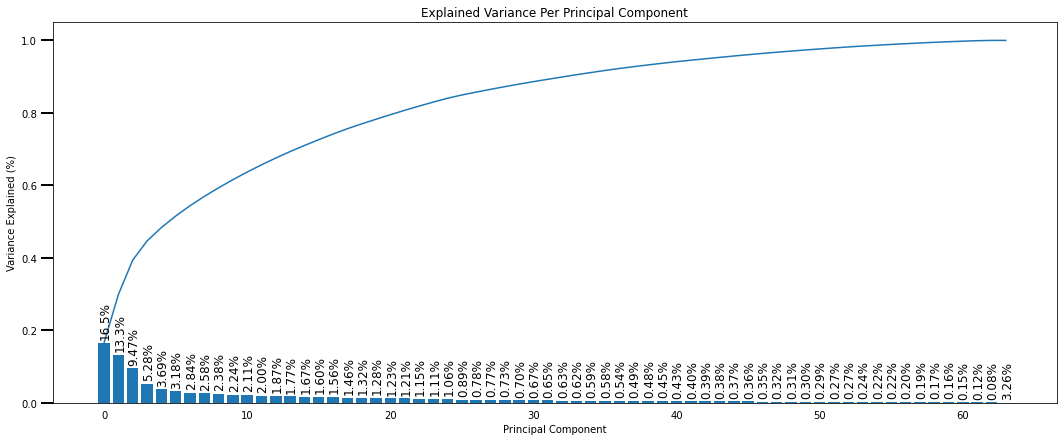

In [30]:
# Investigate the variance accounted for by each principal component
def scree_plot(pca):
    '''
    Create a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 7))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), 
                    (ind[i]+0.1, vals[i]+0.01), 
                    va="bottom", 
                    ha="center", 
                    fontsize=12, 
                    rotation=90)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
# plot a scree plot
scree_plot(pca)

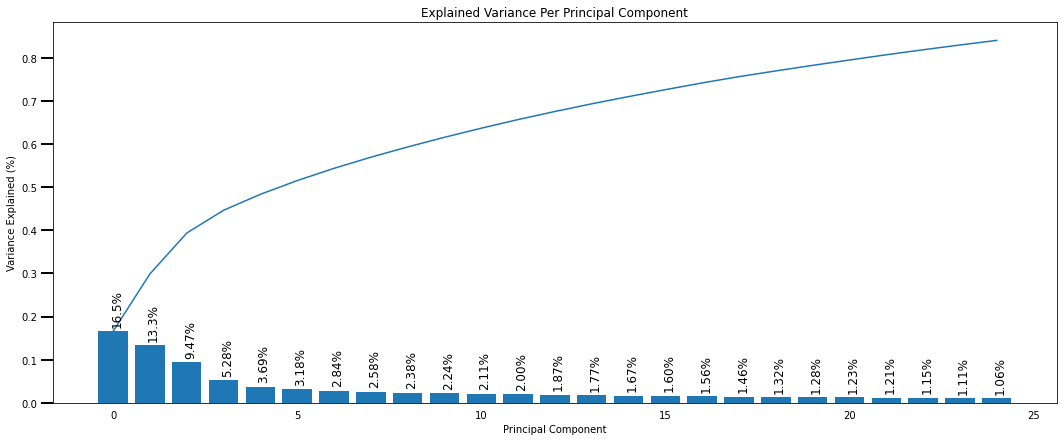

In [31]:
# Re-apply PCA to the data while selecting for number of components to retain
n_components = 25
pca_25, X_pca_25 = do_pca(n_components, azdias_df)
scree_plot(pca_25)

### Discussion 2.2: Perform Dimensionality Reduction

For the first PCA run, I used the same number of components as that of the features. The top three features explained 16.5%, 13.3% and 9.47% of the variance respectively in the data.

Since each of the first 25 components accounted for at least 1% of the variance and also cumulatively they accounted for 85% of the variance, I chose to retain only 25 components for the second PCA run.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [32]:
# Map weights for the first principal component to corresponding feature names & then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells
def get_component_weights(pca, i):
    '''
    Return the top 5 and bottom 5 weights in sorted order for the i th principal component
    
    INPUT: pca - the result of instantian of PCA in scikit learn
           i - i th component of the principal component
        
    OUTPUT: top 5 and bottom 5 weights of the given principal component
    '''
    if i > len(pca.components_):
        return "Invalid entry: no info available for this component"
    
    weights_df = pd.DataFrame({'weight': pca.components_[i]}, index = azdias_df.columns)
    top_5 = weights_df.sort_values(by = ['weight']).head(5)
    bottom_5 = weights_df.sort_values(by = ['weight']).tail(5)
    print("Bottom 5 and Top 5 features and their corresponding weights of Principal Component # {}". format(i+1))
    return pd.concat([top_5, bottom_5], axis = 0, sort = True)

get_component_weights(pca_25, 0)

Bottom 5 and Top 5 features and their corresponding weights of Principal Component # 1


,weight
PLZ8_ANTG1,-0.225640
MOBI_REGIO,-0.224994
FINANZ_MINIMALIST,-0.223028
KBA05_GBZ,-0.216039
KBA05_ANTG1,-0.214531
ORTSGR_KLS9,0.196761
HH_EINKOMMEN_SCORE,0.202297
WEALTH,0.204733
PLZ8_ANTG4,0.216968
PLZ8_ANTG3,0.225336


In [33]:
# Map weights for the second principal component to corresponding feature names & then print the linked values, sorted by weight
get_component_weights(pca_25, 1)

Bottom 5 and Top 5 features and their corresponding weights of Principal Component # 2


,weight
SEMIO_REL,-0.253687
DECADE,-0.238649
FINANZ_SPARER,-0.231680
SEMIO_TRADV,-0.228340
FINANZ_UNAUFFAELLIGER,-0.225508
RETOURTYP_BK_S,0.161940
SEMIO_LUST,0.180171
FINANZ_VORSORGER,0.229253
SEMIO_ERL,0.229960
ALTERSKATEGORIE_GROB,0.256319


In [34]:
# Map weights for the third principal component to corresponding feature names & then print the linked values, sorted by weight
get_component_weights(pca_25, 2)

Bottom 5 and Top 5 features and their corresponding weights of Principal Component # 3


,weight
ANREDE_KZ,-0.367347
SEMIO_KAEM,-0.335067
SEMIO_DOM,-0.313033
SEMIO_KRIT,-0.275021
SEMIO_RAT,-0.217741
FINANZ_MINIMALIST,0.154541
SEMIO_KULT,0.233825
SEMIO_FAM,0.248881
SEMIO_SOZ,0.261933
SEMIO_VERT,0.344684


### Discussion 2.3: Interpret Principal Components


As we have already seen, first principal component accounted for 16.5% of the variability in the data. This component is made up of many features and each feature accounts for anywhere between 0.2% to -0.2% of the variablility in the data. These percentages are called the weights. On the positive side, when the weights of the features increase, the weight of the PCA component also increases. The feeatures that positvely influence the first principal component are 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'WEALTH', 'HH_EINKOMMEN_SCORE', 'ORTSGR_KLS9' and few more. On the other hand, when the weights of the features with negative value increases, the weight of the principal component decreases. These features negatively influence the principal component and they are 'PLZ8_ANTG1', 'MOBI_REGIO', 'FINANZ_MINIMALIST', 'KBA05_GBZ', 'KBA05_ANTG1' and few other.

Similarly, each of the other principal components is made up of a set of features with positive and negative weights. Based on the sign of the weights, the features either positively or negatively influence the principal component they belong to.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [35]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average within-cluster distances
def get_kmeans_score(data, center):
    '''
    Return the kmeans score regarding SSE for points to centers
    
    INPUT: data - the dataset you want to fit kmeans to
           center - the number of centers you want (the k value)
        
    OUTPUT: score - the SSE score for the kmeans model fit to the data
    '''
    kmeans = MiniBatchKMeans(n_clusters = center, batch_size = 2048)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

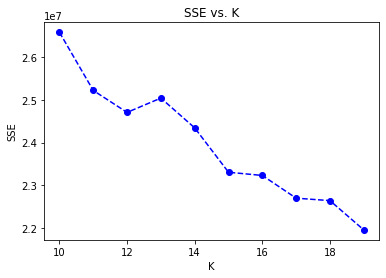

In [36]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship
scores = []
centers = list(range(10,20))

for center in centers:
    scores.append(get_kmeans_score(X_pca_25, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [37]:
# Re-fit the k-means model with the selected # of clusters & obtain predictions for the general population demographics data
kmeans_12 = KMeans(n_clusters = 12)
model_12 = kmeans_12.fit(X_pca_25)
azdias_preds = model_12.predict(X_pca_25)

### Discussion 3.1: Apply Clustering to General Population

KMeans clustering is applied on the PCA-transformed data for different cluster counts ranging from 10 to 19. Using the elbow method, the crook is found to be at count = 12 clusters. At this point, the sum of squared errors (SSE) is lower before it increases for count = 13 clusters. So, I decided to use 12 clusters to segment the data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [38]:
# Load in the customer demographics data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [39]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, 
# obtaining cluster predictions for the customer demographics data

# clean the customers data
customers_cleaned = clean_data(customers)
print("Total number of NaNs before imputation:", customers_cleaned.isnull().sum().sum())

# apply imputer to replace all missing values
customers_df_imputed = pd.DataFrame(imputer.transform(customers_cleaned))
customers_df_imputed.columns = customers_cleaned.columns
customers_df_imputed.index = customers_cleaned.index
print("Total number of NaNs after imputation:", customers_df_imputed.isnull().sum().sum())

# apply feature scaling
customers_df = pd.DataFrame(std_scaler.transform(customers_df_imputed))
customers_df.columns = customers_df_imputed.columns
customers_df.index = customers_df_imputed.index

# transform customers data using PCA
customers_X_pca_25 = pca_25.transform(customers_df)

# obtain cluster prediction for customers data
customers_preds = model_12.predict(customers_X_pca_25)

Original shape of the dataframe: (191652, 85)
Total number of original NaNs: 2252274
Total number of NaNs after converting 'missing' and 'unknown' values: 3112918
Shape after dropping columns with many NaNs: (191652, 79)
Shape after dropping rows with many NaNs: (141590, 79)
Shape after re-encoding / dropping categorical variables: (141590, 66)
Shape after re-engineering / dropping mixed-type variables: (141590, 64)
Final shape of the dataframe: (141590, 64)
Total number of NaNs before imputation: 102081
Total number of NaNs after imputation: 0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

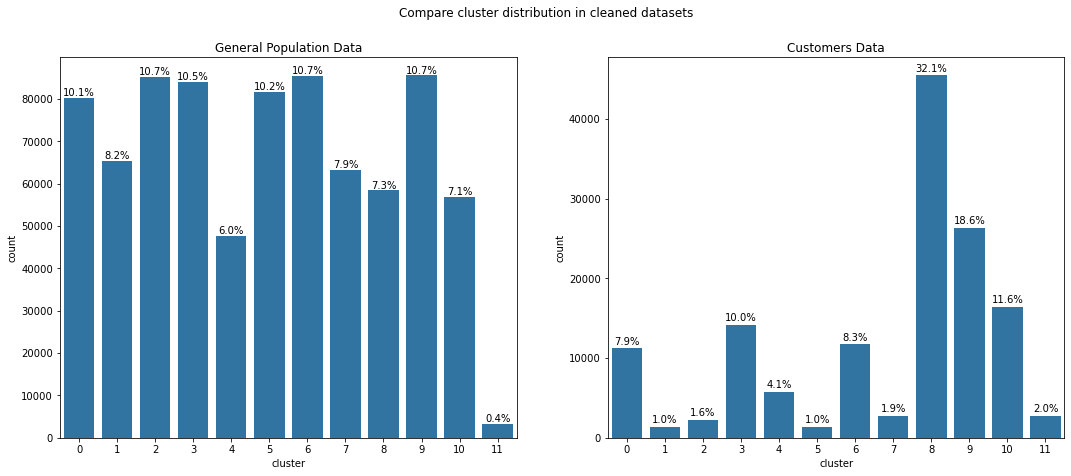

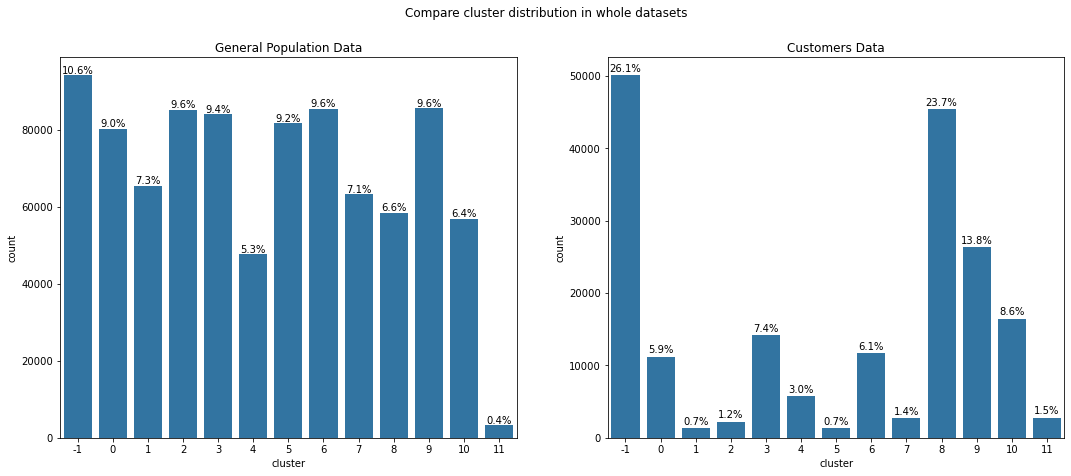

In [40]:
# Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the 
# general population

# convert cluster predictions into a dataframe
azdias_preds_df = pd.DataFrame(azdias_preds, columns = ['cluster'])
customers_preds_df = pd.DataFrame(customers_preds, columns = ['cluster'])

# define a function to add previously removed rows as cluster -1
def add_nan_rows(df, count):
    '''
    Return the updated dataframe with new rows appended as cluster -1
    
    INPUT: df - dataframe to which new rows are appended
           count - number of rows to append
        
    OUTPUT: updated dataframe with added rows 
    '''
    value_list = list(-1 for i in range(count))
    nan_df = pd.DataFrame(value_list, columns = ['cluster'])
    return df.append(nan_df)

# convert entire cluster predictions including previously removed rows into a dataframe
azdias_preds_df_whole = add_nan_rows(azdias_preds_df, len(azdias)-len(azdias_df))
customers_preds_df_whole = add_nan_rows(customers_preds_df, len(customers)-len(customers_df))

# define a function to plot the distribution of clusters
def dist_plot(title, set1, set2):
    '''
    Compare distribution of clusters between two datasets
    
    INPUT: title - title of the plot
           set1 - first dataset
           set2 - second dataset
           
    OUTPUT: None 
    '''
    f, axes = plt.subplots(1, 2, figsize=(18, 7))
    f.suptitle("Compare cluster distribution in {} datasets".format(title))
    axes[0].set_title("General Population Data")
    axes[1].set_title("Customers Data")
    base_color = sns.color_palette()[0]

    axes[0] = sns.countplot(x = "cluster", data = set1, ax = axes[0], color = base_color)
     
    for i in axes[0].patches:
        height = i.get_height()
        axes[0].text(i.get_x()+i.get_width()/2., height+500, "{:1.1f}%".format(height*100/float(len(set1))), ha = "center")  
        
    axes[1] = sns.countplot(x = "cluster", data = set2, ax = axes[1], color = base_color)    
        
    for i in axes[1].patches:
        height = i.get_height()
        axes[1].text(i.get_x()+i.get_width()/2., height+500, "{:1.1f}%".format(height*100/float(len(set2))), ha = "center")     

# plot the cluster distribution
dist_plot("cleaned", azdias_preds_df, customers_preds_df)
dist_plot("whole", azdias_preds_df_whole, customers_preds_df_whole)

In [41]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

# define a function to get the top features in a given cluster
def get_features(cluster):
    '''
    Return the top features for the provided cluster
    
    INPUT: cluster - cluster number for which features are required
        
    OUTPUT: Print the list of top features
    '''
    cluster_centroid = std_scaler.inverse_transform(pca_25.inverse_transform(model_12.cluster_centers_[cluster]))
    print("Top features in cluster {} are:".format(cluster))
    for f, c in enumerate(cluster_centroid):
        if np.abs(c) > 10:
            print("feature {}: {}".format(f, c))
            print("  feature {} is {}".format(f, customers_df.columns[f]))

# get the top features in cluster 8             
get_features(8)

Top features in cluster 8 are:
feature 35: 1993.1249460763293
  feature 35 is MIN_GEBAEUDEJAHR
feature 50: 696.3830476444114
  feature 50 is KBA13_ANZAHL_PKW
feature 60: 65.99834793955945
  feature 60 is DECADE


In [42]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

# get the top features in cluster 5 
get_features(5)

Top features in cluster 5 are:
feature 32: 13.648933474424027
  feature 32 is ANZ_HAUSHALTE_AKTIV
feature 35: 1992.5520493161673
  feature 35 is MIN_GEBAEUDEJAHR
feature 50: 533.6452508314287
  feature 50 is KBA13_ANZAHL_PKW
feature 60: 86.80718721842085
  feature 60 is DECADE


### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 8 is overreprensented in the customer data when compared to the general population. 32.1% of the customers are in this cluster as opposed to only 7.3% of the general population. Even after taking into account the deleted rows due to many missing values, the overrepresentation holds good - 23.7% of customers are in this cluster against only 6.6% of general population.

Analysing cluster 8, it is found that the top three features represented are:
>- MIN_GEBAEUDEJAHR - First year building was mentioned in the database (Building-level feature)
>- KBA13_ANZAHL_PKW - Number of cars in the PLZ8 region (PLZ8 macro-cell feature)
>- DECADE - re-engineered from PRAEGENDE_JUGENDJAHRE representing decade of a person's youth (Personal-level feature)

Cluster 5 is underreprensented in the customer data when compared to the general population. Only 1% of the customers are in this cluster as opposed to 10.2% of the general population. Even after taking into account the deleted rows due to many missing values, the underrepresentation holds good - only 0.7% of customers are in this cluster against 9.2% of general population.

Analysing cluster 5, it is found that the top four features represented are:
>- MIN_GEBAEUDEJAHR - First year building was mentioned in the database (Building-level feature)
>- KBA13_ANZAHL_PKW - Number of cars in the PLZ8 region (PLZ8 macro-cell feature)
>- DECADE - re-engineered from PRAEGENDE_JUGENDJAHRE representing decade of a person's youth (Personal-level feature)
>- ANZ_HAUSHALTE_AKTIV - Number of households in the building (Building-level feature)

So, almost the same features decide the popularity or unpopularity of segments of the population with the mail-order company. Whether a person is a customer or not depends on the value of these features. For example, a person living in a PLZ8 region with many cars (KBA13_ANZAHL_PKW) may be expected to respond to the mail-order and hence be a customer than a person living in a PLZ8 region with fewer cars.